In [3]:
import matplotlib.pyplot as plt

"""
Small demo to illustrate how the plot function and the gridworld environment work
"""
import numpy as np
import optuna
from gridworld import *
from plot import *

COUNT_ENVIRONMENT = 10

In [4]:
def select_action(eps, decay,episode, state, q_table):
    """
    This function determines which action to take in a given state. Decaying-Epsilon-Greedy is used to return a random action or the best possible action.
    Parameters:
        eps: Parameter for Decaying-Epsilon-Greedy Algorithm
        decay: Parameter for Decaying-Epsilon-Greedy Algorithm
        episode: current episode. Used for Decaying-Epsilon-Greedy Algorithm
        state: Current state of the Episode
        q_table: Current Q-table
    
    Returns:
        Action to take in a given state
    """
    # do random action
    if np.random.random() < eps/(decay*(episode+1)):
        return np.random.randint(0, len(q_table[0]))
    # or do best action
    else:
        return np.argmax(q_table[state])


In [5]:
def sarsa(env, alpha, gamma, episodes, max_episode_length, init_reward, eps, decay):
    """
    This function performs the SARSA algorithm on a given GridWorld environment
    Parameters:
        env: Environment to perform Q-Learning on. 
        alpha: Learning rate
        gamma: Discount factor
        episodes: Number of episodes to perform
        max_episode_length: Maximum length of an episode
        init_reward: Initial reward for every possible action
        eps: Chance to perform a random action
        decay: Parameter for decaying epsilon-greedy
    
    Return:
         Dictionary of shape: environment_N: { episode_M: { [steps_taken_in_episode, reward_from_episode] } }
    """
    q_table = np.zeros((env.num_states(), env.num_actions()))
    q_table.fill(init_reward)
    learning_data={}
    cum_reward = 0
    # run a certain number of episodes
    for episode in range(episodes):
        state = env.reset()
        action = select_action(eps, decay,episode, state, q_table)

        done = False
        episode_length = 0

        # run episode until a goal state or the maximum number of steps has been reached
        while not done and episode_length < max_episode_length:
            next_state, reward, done = env.step(action)
            next_action = select_action(eps, decay,episode, next_state, q_table)            
            
            # Q-Learning update rule
            delta = reward + gamma * q_table[next_state, next_action] * (done < 0.5) - q_table[state, action]
            q_table[state, action] += alpha * delta
            cum_reward += alpha * delta
            
            state = next_state
            action = next_action
            episode_length += 1
            
        learning_data[episode] = [episode_length, cum_reward]

    return learning_data


In [6]:
def qlearning(env, alpha, gamma, episodes, max_episode_length, init_reward, eps, decay):
    """
    This function performs the Q-Learning algorithm on a given GridWorld environment
    Parameters:
        env: Environment to perform Q-Learning on. 
        alpha: Learning rate
        gamma: Discount factor
        episodes: Number of episodes to perform
        max_episode_length: Maximum length of an episode
        init_reward: Initial reward for every possible action
        eps: Chance to perform a random action
        decay: Parameter for decaying epsilon-greedy
    
    Return:
         Dictionary of shape: environment_N: { episode_M: { [steps_taken_in_episode, reward_from_episode] } }
    """
    
    q_table = np.zeros((env.num_states(), env.num_actions()))
    q_table.fill(init_reward)
    learning_data={}
    cum_reward = 0
    # run a certain number of episodes
    for episode in range(episodes):
        state = env.reset()
        action = select_action(eps, decay,episode, state, q_table)

        done = False
        episode_length = 0

        # run episode until a goal state or the maximum number of steps has been reached
        while not done and episode_length < max_episode_length:
            next_state, reward, done = env.step(action)
            next_action = select_action(eps, decay,episode, next_state, q_table)            
            
            # Q-Learning update rule
            delta = reward + gamma * np.max(q_table[next_state, next_action]) * (done < 0.5) - q_table[state, action]
            q_table[state, action] += alpha * delta
            cum_reward += alpha * delta
            
            state = next_state
            action = next_action
            episode_length += 1
            
        learning_data[episode] = [episode_length, cum_reward]

    return learning_data


In [28]:
def run_study():
    study = optuna.create_study(study_name='DRL_Studienarbeit1_A1_sarsa', storage='sqlite:///DRL_Studienarbeit1_A1_sarsa.db',load_if_exists=True, direction='maximize')
    study.optimize(sarsa, n_trials=3000)

In [ ]:
run_study()

# Plot 1: Cumulative reward of the current episode over episodes

In [7]:
#Hyperparameters found via optuna in DRL_Studienarbeit1_A1.db
#Optimized for cumulative reward/episode count
Q_ALPHA = 0.19119333605152306
Q_GAMMA =  0.999748200802963
Q_EPISODES = 200
Q_MAX_EPISODE_LENGTH = 42613
Q_INIT_REWARD = 4
Q_EPS = 0.01972098758840051
Q_DECAY = 0.7262144470920912

#SARSA
SARSA_ALPHA = 0.29746782448189185
SARSA_GAMMA = 0.9995697307876407
SARSA_EPISODES = 169
SARSA_MAX_EPISODE_LENGTH = 990
SARSA_INIT_REWARD = 0
SARSA_EPS = 0.9708745687550547
SARSA_DECAY = 0.44025244936731933

In [8]:
def plot_A1(qlearning_data, sarsa_data):
    qlearning_x_avg = np.zeros(Q_EPISODES)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
    plt.subplots_adjust(wspace=20, right=0.7)
    for i in range(qlearning_data.keys().__len__()):
        qlearning_x = [value[1] for value in list(qlearning_data[i].values())]
    
        qlearning_x_avg = [sum(x) for x in zip(qlearning_x, qlearning_x_avg)]
        
        ax1.plot(range(Q_EPISODES), qlearning_x, label='Env ' + str(i), alpha = 0.3)
    
    qlearning_x_avg = [a/10 for a in qlearning_x_avg]    
    ax1.plot(range(Q_EPISODES),qlearning_x_avg, '--', label="Average")
    
    ax1.set_xlabel('Episode', fontdict={'size':15})
    ax1.set_ylabel('Cumulative reward', fontdict={'size':15})
    ax1.set_title('Q-Learning', fontdict={'size':15})
    ax1.set_ylim(min(val for inner_dict in qlearning_data.values() for inner_list in inner_dict.values() for val in inner_list), max(val for inner_dict in qlearning_data.values() for inner_list in inner_dict.values() for val in inner_list))

    ax1.set_xlim(0,200)
    
    #SARSA
    sarsa_x_avg = np.zeros(SARSA_EPISODES)
    for i in range(sarsa_data.keys().__len__()):
        sarsa_x = [value[1] for value in list(sarsa_data[i].values())]
    
        sarsa_x_avg = [sum(x) for x in zip(sarsa_x, sarsa_x_avg)]
        
        ax2.plot(range(SARSA_EPISODES), sarsa_x, label='Env ' + str(i), alpha = 0.3)
    
    sarsa_x_avg = [a/10 for a in sarsa_x_avg]    
    ax2.plot(range(SARSA_EPISODES),sarsa_x_avg, '--', label="Average")    

    ax2.set_xlabel('Episode', fontdict={'size':15})
    ax2.set_title('SARSA', fontdict={'size':15})
    ax2.set_ylim(min(val for inner_dict in sarsa_data.values() for inner_list in inner_dict.values() for val in inner_list), max(val for inner_dict in sarsa_data.values() for inner_list in inner_dict.values() for val in inner_list))
    ax2.set_xlim(0,169)    
    fig.suptitle("Cumulative reward over episodes", fontsize=25)
    
    lines_labels = ax1.get_legend_handles_labels() 
    lines, labels = [sum(lol, []) for lol in zip(lines_labels)]
    fig.legend( lines, labels, bbox_to_anchor=(1, 0.84),loc='upper left', ncol=1)

    fig.tight_layout()
    plt.show()

In [9]:
qlearning_data={}
sarsa_data={}
envs_A1 = []

for i in range(COUNT_ENVIRONMENT):
    env = Random(size=12, water=0.3, mountain=0)
    envs_A1.append(env)        
    qlearning_data[i] = qlearning(env, Q_ALPHA, Q_GAMMA, Q_EPISODES, Q_MAX_EPISODE_LENGTH, Q_INIT_REWARD, Q_EPS, Q_DECAY)
    sarsa_data[i] = sarsa(env, SARSA_ALPHA, SARSA_GAMMA, SARSA_EPISODES, SARSA_MAX_EPISODE_LENGTH, SARSA_INIT_REWARD, SARSA_EPS, SARSA_DECAY)
    

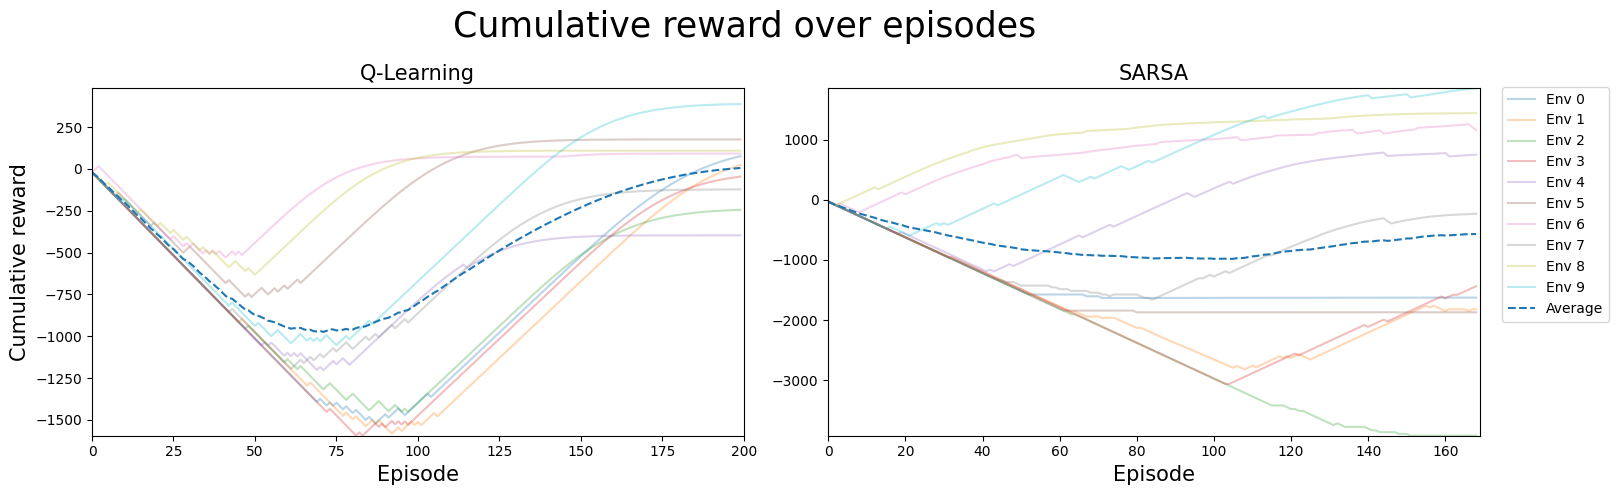

In [10]:
plot_A1(qlearning_data, sarsa_data)

# Plot 2: Cumulative reward over amount of steps

In [11]:
#Hyperparameters found via optuna in DRL_Studienarbeit1_A2.db
#optimized for cumulative reward/episode length
Q_ALPHA_A2 = 0.6660010689218203
Q_GAMMA_A2 =  0.9955785729498876
Q_EPISODES_A2 = 11620
Q_MAX_EPISODE_LENGTH_A2 = 1544
Q_INIT_REWARD_A2 = 5
Q_EPS_A2 = 0.5579320801207901
Q_DECAY_A2 = 0.1763870404498077

#SARSA
SARSA_ALPHA_A2= 0.8893905832326342
SARSA_GAMMA_A2 = 0.9998465053914064
SARSA_EPISODES_A2 = 3660
SARSA_MAX_EPISODE_LENGTH_A2 = 1002
SARSA_INIT_REWARD_A2 = 6
SARSA_EPS_A2 = 0.6983191701356518
SARSA_DECAY_A2 = 0.04701427863697144

In [12]:
def plot_A2(qlearning_data, sarsa_data):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
    plt.subplots_adjust(wspace=20, right=0.7)
    qlearning_x_avg = np.zeros((Q_EPISODES_A2))
    qlearning_y_avg = np.zeros((Q_EPISODES_A2))
    for i in range(qlearning_data.keys().__len__()):
        qlearning_x = np.cumsum([value[0] for value in list(qlearning_data[i].values())])
        qlearning_y = np.cumsum([value[1] for value in list(qlearning_data[i].values())])
        
        qlearning_x_avg = [sum(x) for x in zip(qlearning_x, qlearning_x_avg)]
        
        qlearning_y_avg = [sum(y) for y in zip(qlearning_y, qlearning_y_avg)]
        
        ax1.plot(qlearning_x, qlearning_y, label=i, alpha=0.2)
    
    qlearning_x_avg = [a/10 for a in qlearning_x_avg]
    qlearning_y_avg = [a/10 for a in qlearning_y_avg]
    
    ax1.plot(qlearning_x_avg, qlearning_y_avg, '--',label="avg")
    
    # Adding labels and title
    ax1.set_xlabel('number of steps', fontdict={'size':15})
    ax1.set_ylabel('Cumulative reward', fontdict={'size':15})
    ax1.set_title('Q-Learning', fontdict={'size':15})
    ax1.set_ylim(min(val for inner_dict in qlearning_data.values() for inner_list in inner_dict.values() for val in inner_list), max(val for inner_dict in qlearning_data.values() for inner_list in inner_dict.values() for val in inner_list))
    ax1.set_xlim(0,9000)
    
    #SARSA
    sarsa_x_avg = np.zeros((SARSA_EPISODES_A2))
    sarsa_y_avg = np.zeros((SARSA_EPISODES_A2))
    for i in range(qlearning_data_A2.keys().__len__()):
        sarsa_x = np.cumsum([value[0] for value in list(sarsa_data[i].values())])
        sarsa_y = np.cumsum([value[1] for value in list(sarsa_data[i].values())])
        
        sarsa_x_avg = [sum(x) for x in zip(sarsa_x, sarsa_x_avg)]
        
        sarsa_y_avg = [sum(y) for y in zip(sarsa_y, sarsa_y_avg)]
        
        plt.plot(sarsa_x, sarsa_y, label=i, alpha=0.2)
    
    sarsa_x_avg = [a/10 for a in sarsa_x_avg]
    sarsa_y_avg = [a/10 for a in sarsa_y_avg]
    
    plt.plot(sarsa_x_avg, sarsa_y_avg, '--',label="avg")
    
    # Adding labels and title
    ax2.set_xlabel('number of steps', fontdict={'size':15})
    ax2.set_title('SARSA', fontdict={'size':15})
    ax2.set_ylim(min(val for inner_dict in sarsa_data.values() for inner_list in inner_dict.values() for val in inner_list), max(val for inner_dict in sarsa_data.values() for inner_list in inner_dict.values() for val in inner_list))
    ax2.set_xlim(0,9000)
    
    fig.suptitle("total number of steps over Cumulative reward", fontsize=25)
    
    lines_labels = ax1.get_legend_handles_labels() 
    lines, labels = [sum(lol, []) for lol in zip(lines_labels)]
    fig.legend( lines, labels, bbox_to_anchor=(1, 0.84),loc='upper left', ncol=1)
    
    fig.tight_layout()
    plt.show()

In [13]:
qlearning_data_A2={}
sarsa_data_A2={}
envs2 = []

for i in range(COUNT_ENVIRONMENT):
    env = Random(size=12, water=0, mountain=0.3)
    envs2.append(env)
    qlearning_data_A2[i] = qlearning(env, Q_ALPHA_A2, Q_GAMMA_A2, Q_EPISODES_A2, Q_MAX_EPISODE_LENGTH_A2, Q_INIT_REWARD_A2, Q_EPS_A2, Q_DECAY_A2)
    sarsa_data_A2[i] = sarsa(env, SARSA_ALPHA_A2, SARSA_GAMMA_A2, SARSA_EPISODES_A2, SARSA_MAX_EPISODE_LENGTH_A2, SARSA_INIT_REWARD_A2, SARSA_EPS_A2, SARSA_DECAY_A2)


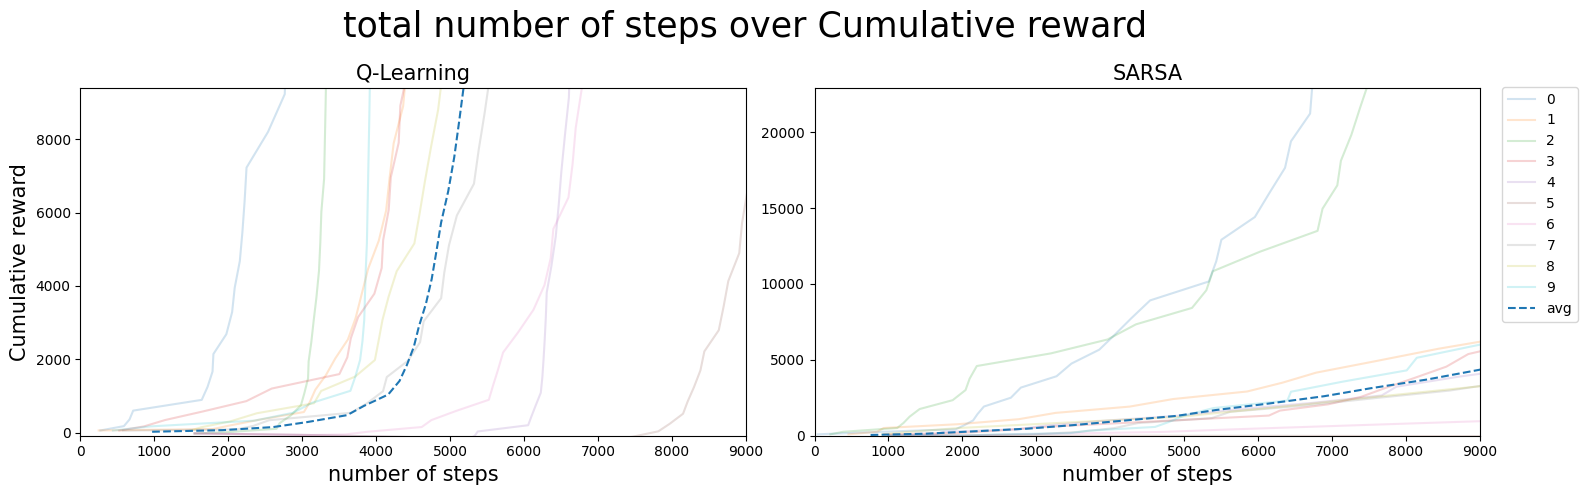

In [14]:
plot_A2(qlearning_data_A2, sarsa_data_A2)